Studiul utilizează setul de date empiric UrbanEV, colectat în Shenzhen, China (sept. 2022 - feb. 2023), un etalon global pentru mobilitatea electrică.

Monitorizează 1.682 stații de încărcare publică pe parcursul a 6 luni.

Include gradul de ocupare, durata sesiunilor, volumul de energie, prețul dinamic și condițiile meteo.

Aceste date calibrează simularea noastră (sosiri, durate), asigurând un comportament realist al cererii de încărcare.

In [60]:
!pip install simpy

In [61]:
from google.colab import files

uploaded = files.upload()


Saving occupancy.csv to occupancy (4).csv
Saving duration.csv to duration (4).csv


Fișierul 'occupancy.csv' conține date despre numărul de mașini de la o anumită stație la o anumită dată și oră, iar duration.csv reprezintă cât a stat masina respectivă la stația de încărcare respectivă




Folosim cele 2 fișiere în simulare pentru a dicta comportamentul agenților:
  occupancy.csv (Cererea): Calibrează Rata de Sosire ($\lambda$). Transformă

*    occupancy.csv (Cererea): Calibrează Rata de Sosire ($\lambda$). Transformă gradul istoric de ocupare în probabilități de sosire, captând fidel vârfurile de trafic și activitatea intensă din weekend.

*   duration.csv (Procesarea): Calibrează Timpul de Serviciu ($\mu$). Determină
durata blocării stațiilor pe baza mediei reale (~15 min), reflectând un model operațional de tip Fast Charging (rulaj rapid).


  

Am modelat 2 scenarii, bazându-mă în primul pe datele regăsite in articol, iar în al doilea am simulat un scenariu ipotetic în felul următor:

1. Scenariul A: Prezentul Sustenabil (Baseline) Parametrii utilizați (12% adopție EV, 82% încărcare acasă) sunt fundamentați empiric pe datele din raportul "2024/2025 Global EV Outlook". Aceștia reflectă profilul actual al utilizatorilor ("Early Adopters"), care dispun preponderent de garaje private, minimizând astfel presiunea pe rețeaua publică.
https://www.iea.org/reports/global-ev-outlook-2024

2. Scenariul B: Viitorul Critic (Stress Test) Acest scenariu ipotetic simulează adopția în masă (70% EV), dar într-un context urban dens unde infrastructura privată lipsește (doar 10% încărcare acasă). Inversarea proporțiilor testează limita de colaps a sistemului, modelând o situație în care majoritatea șoferilor locuiesc la bloc și devin 100% dependenți de stațiile publice.

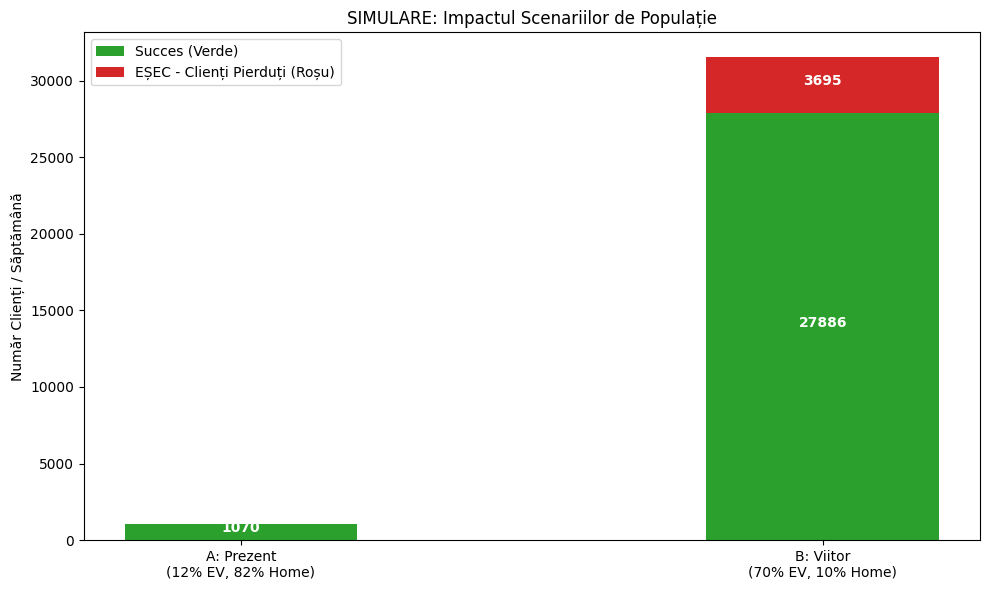

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import heapq

occupancy = pd.read_csv('occupancy.csv', index_col=0, parse_dates=True)
duration = pd.read_csv('duration.csv', index_col=0, parse_dates=True)


occ_mean = occupancy.mean(axis=1)
hourly_weights = occ_mean.groupby(occ_mean.index.hour).mean()
hourly_prob_dist = hourly_weights / hourly_weights.sum()

hourly_dur_mean = duration.groupby(duration.index.hour).mean().mean(axis=1).to_dict()
hourly_dur_std = duration.groupby(duration.index.hour).std().mean(axis=1).to_dict()


# 2. MOTOR DE SIMULARE
STATION_CAPACITIES = [8, 12, 6, 10, 8, 12, 6, 8, 4]
NUM_STATIONS = len(STATION_CAPACITIES)

def run_simulation(total_pop, ev_rate, home_rate):
    public_users = total_pop * ev_rate * (1 - home_rate)

    weekly_sessions = public_users

    stations_state = [[] for _ in range(NUM_STATIONS)]
    stats = {'served': 0, 'lost': 0}

    minutes_in_week = 7 * 24 * 60

    for minute in range(minutes_in_week):
        hour = (minute // 60) % 24

        for i in range(NUM_STATIONS):
            while stations_state[i] and stations_state[i][0] <= minute:
                heapq.heappop(stations_state[i])

        daily_sessions = weekly_sessions / 7.0
        sessions_this_hour = daily_sessions * hourly_prob_dist.get(hour, 1/24)
        lambda_val = sessions_this_hour / 60.0

        num_arrivals = np.random.poisson(lambda_val)

        for _ in range(num_arrivals):
            idx = random.randint(0, NUM_STATIONS - 1)

            if len(stations_state[idx]) < STATION_CAPACITIES[idx]:
                stats['served'] += 1

                d_mean = hourly_dur_mean.get(hour, 15)
                d_std = hourly_dur_std.get(hour, 5)
                dur = max(5, random.gauss(d_mean, d_std))

                heapq.heappush(stations_state[idx], minute + dur)
            else:
                stats['lost'] += 1

    return stats


# Scenariul A: Prezent (12% EV, 82% Home Charging)
stats_A = run_simulation(50000, 0.12, 0.82)

# Scenariul B: Viitor Agresiv (70% EV, 10% Home Charging)
# Aici vedem impactul real al lipsei de infrastructură privată
stats_B = run_simulation(50000, 0.70, 0.10)


labels = ['A: Prezent\n(12% EV, 82% Home)', 'B: Viitor\n(70% EV, 10% Home)']
served = [stats_A['served'], stats_B['served']]
lost = [stats_A['lost'], stats_B['lost']]
x = np.arange(len(labels))

plt.figure(figsize=(10, 6))
p1 = plt.bar(x, served, width=0.4, label='Succes (Verde)', color='#2ca02c')
p2 = plt.bar(x, lost, width=0.4, bottom=served, label='EȘEC - Clienți Pierduți (Roșu)', color='#d62728')

plt.ylabel('Număr Clienți / Săptămână')
plt.title('SIMULARE: Impactul Scenariilor de Populație')
plt.xticks(x, labels)
plt.legend()

for i in range(len(x)):
    plt.text(x[i], served[i]/2, str(served[i]), ha='center', color='white', fontweight='bold')
    if lost[i] > 0:
        plt.text(x[i], served[i] + lost[i]/2, str(lost[i]), ha='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

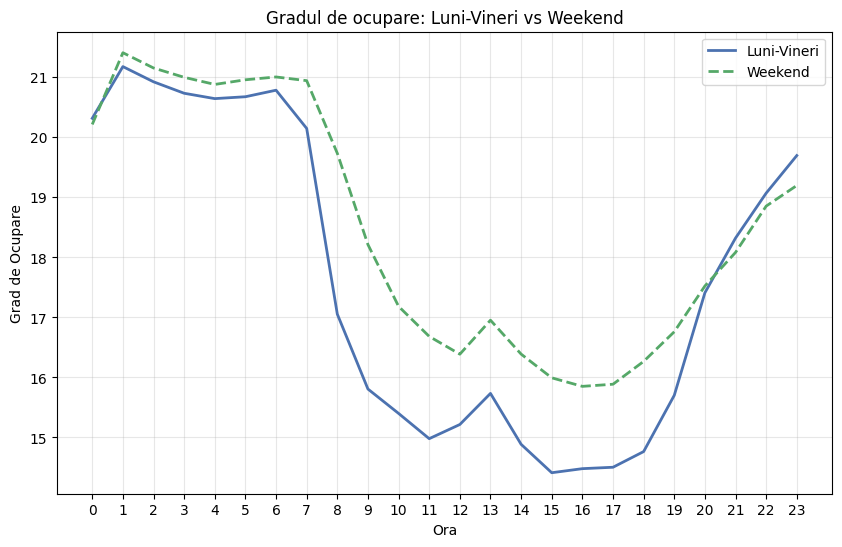

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

occupancy = pd.read_csv('occupancy.csv', index_col=0, parse_dates=True)
avg_occ = occupancy.mean(axis=1)

df = pd.DataFrame({'Occupancy': avg_occ})
df['Hour'] = df.index.hour
df['Type'] = df.index.dayofweek.map(lambda x: 'Weekend' if x >= 5 else 'Luni-Vineri')

profile_wk = df[df['Type'] == 'Luni-Vineri'].groupby('Hour')['Occupancy'].mean()
profile_wd = df[df['Type'] == 'Weekend'].groupby('Hour')['Occupancy'].mean()

plt.figure(figsize=(10, 6))
plt.plot(profile_wk, label='Luni-Vineri', color='#4c72b0', linewidth=2)
plt.plot(profile_wd, label='Weekend', color='#55a868', linewidth=2, linestyle='--')

plt.title('Gradul de ocupare: Luni-Vineri vs Weekend')
plt.xlabel('Ora')
plt.ylabel('Grad de Ocupare')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))
plt.show()

                     mean        50%        75%        90%        95%  \
Period                                                                  
Noapte (22-06)  18.317972  10.000000  22.000000  48.166667  64.000000   
Zi (06-22)      13.576248   8.166667  17.083333  33.000000  44.416667   

                       max  
Period                      
Noapte (22-06)  207.583333  
Zi (06-22)      200.083333  


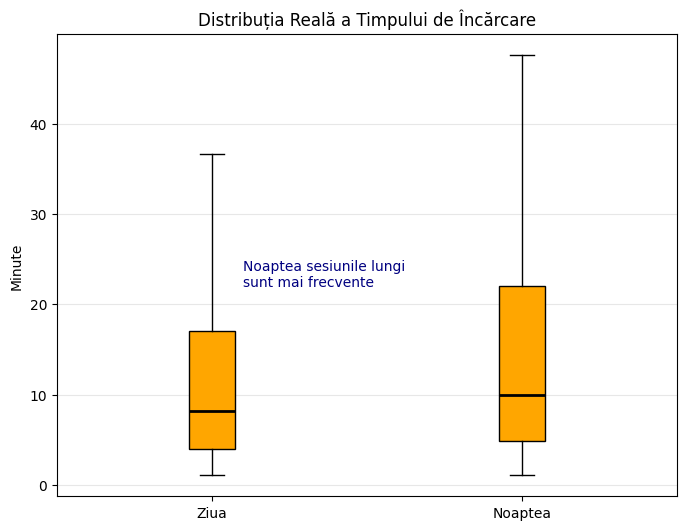

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

duration = pd.read_csv('duration.csv', index_col=0, parse_dates=True)
df_long = duration.stack().reset_index()
df_long.columns = ['Time', 'Station', 'Duration']
df_long = df_long[df_long['Duration'] > 1]

df_long['Hour'] = df_long['Time'].dt.hour
df_long['Period'] = df_long['Hour'].apply(lambda x: 'Noapte (22-06)' if (x>=22 or x<6) else 'Zi (06-22)')

stats = df_long.groupby('Period')['Duration'].describe(percentiles=[0.5, 0.75, 0.9, 0.95])
print(stats[['mean', '50%', '75%', '90%', '95%', 'max']])

plt.figure(figsize=(8, 6))
data_zi = df_long[df_long['Period'] == 'Zi (06-22)']['Duration']
data_noapte = df_long[df_long['Period'] == 'Noapte (22-06)']['Duration']

plt.boxplot([data_zi, data_noapte], tick_labels=['Ziua', 'Noaptea'], showfliers=False, patch_artist=True,
            boxprops=dict(facecolor='#ffa600', color='black'),
            medianprops=dict(color='black', linewidth=2))

plt.title('Distribuția Reală a Timpului de Încărcare')
plt.ylabel('Minute')
plt.grid(axis='y', alpha=0.3)

plt.text(1.1, stats.loc['Noapte (22-06)', '75%'], 'Noaptea sesiunile lungi\nsunt mai frecvente',
         color='navy', fontsize=10)

plt.show()